- odds = P(Y=1)/P(Y=0)
- odds = e^(B0 + B1X1 + B2X2 + ... + BkXk)
- Logit = log(odds) = B0 + B1X1 + B2X2 + ... + BkXk
- P(y = 1) = 1/(1 + e^(-Logit))

Confusion Matrix
- Accuracy = (TP+TN)/(TP+TN+FP+FN)
- Sensitivity = Recall = TP Rate = TP/(TP+FN)
- Specificity = TN Rate = TN/(TN+FP)
- Precision = TP/(TP+FP)

- F-measure = 2/((1/precision)+(1/recall))


In [1]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import seaborn as sns
sns.set_style('darkgrid')

from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cross_validation import train_test_split
# from sklearn import datasets, linear_model, metrics
import sklearn.linear_model as lm

#import itertools
#import pandas_datareader.data as pdweb
#from pandas_datareader.data import DataReader
#from datetime import datetime
#from io import StringIO

In [2]:
raw_df = pd.read_csv('../data/quality.csv')
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131 entries, 0 to 130
Data columns (total 14 columns):
MemberID                131 non-null int64
InpatientDays           131 non-null int64
ERVisits                131 non-null int64
OfficeVisits            131 non-null int64
Narcotics               131 non-null int64
DaysSinceLastERVisit    131 non-null float64
Pain                    131 non-null int64
TotalVisits             131 non-null int64
ProviderCount           131 non-null int64
MedicalClaims           131 non-null int64
ClaimLines              131 non-null int64
StartedOnCombination    131 non-null bool
AcuteDrugGapSmall       131 non-null int64
PoorCare                131 non-null int64
dtypes: bool(1), float64(1), int64(12)
memory usage: 13.5 KB


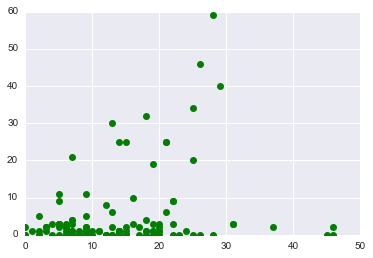

In [3]:
plt.plot(raw_df['OfficeVisits'],raw_df['Narcotics'],'go')

(0, 70.0)

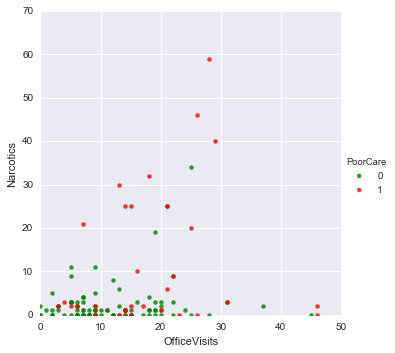

In [4]:
colors = ['green','red']
sns.lmplot(x='OfficeVisits',y='Narcotics',data=raw_df,fit_reg=False, hue='PoorCare',palette=colors)
sns.plt.xlim(0,)
sns.plt.ylim(0,)

In [5]:
pd.crosstab(raw_df['PoorCare'], raw_df['PoorCare'].count(), colnames=['Row_Count'])

Row_Count,131
PoorCare,
0,98
1,33


#### baseline prediction

In classification problems, we just predict the most common result, in this case we predict 0. And in this case, we would be correct 98/131 = 75% of the time.  That's our baseline 'dumb' approach.

In [6]:
qualityTrain, qualityTest = train_test_split(raw_df, test_size=0.25)
print('train has:',len(qualityTrain),'\ntest has:',len(qualityTest))

train has: 98 
test has: 33


In [7]:
# predictor_col = ['OfficeVisits','Narcotics']

# LogReg = lm.LogisticRegression()
# LogReg.fit(qualityTrain[predictor_col],qualityTrain['PoorCare'])

LogReg = smf.GLM.from_formula(formula='PoorCare ~ OfficeVisits + Narcotics',data=qualityTrain,family=sm.families.Binomial()).fit()
LogReg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               PoorCare   No. Observations:                   98
Model:                            GLM   Df Residuals:                       95
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -44.882
Date:                Fri, 29 Jul 2016   Deviance:                       89.764
Time:                        14:33:07   Pearson chi2:                     101.
No. Iterations:                     7                                         
================================================================================
                   coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept       -2.5184      0.538     -4.680      0.000        -3.573    -1.464
OfficeVisits     0.0640      0.030      2.116      0.034         0.005     0.123
Narcotics        0.1023      0.039      2.630      0.009         0.026     0.179
================================================================================
"""

In [8]:
# print(predictor_col,':')
# print(LogReg.coef_)
# print()
# print('intercept:')
# print(LogReg.intercept_)

print(LogReg.params)

Intercept      -2.599956
OfficeVisits    0.072276
Narcotics       0.093312
dtype: float64


#### Preferred model is the one with the minimum AIC.  But how do we compute AIC?

- In Wikipedia:  AIC = 2k + n [Ln( 2(pi) RSS/n ) + 1],

- In a referenced article:  AIC = 2k + n Log(RSS/n), 

- In a published paper:  AIC = k + n [Ln( 2(pi) RSS/(n-k) ) +1],

RSS = Residual Sum of Squares = ???

k = number of model parameters

In [9]:
# If same as OLS model, then AIC is computed like this:
print ('AIC is: ',2*(2+1) - 2*LogReg.llf)

# AIC can only be compared among models with the same dataset.

AIC is:  97.8702762019


In [10]:
predictTrain = LogReg.predict(linear=False)

In [11]:
print('min: ',predictTrain.min())
print('mean: ',predictTrain.mean())
print('median: ',np.median(predictTrain))
print('max: ',predictTrain.max())

min:  0.0821043601585
mean:  0.265306122449
median:  0.183203587277
max:  0.989606144731


In [45]:
#For true poor care cases (PoorCare = 1), what is the average probability that we predicted?
#For true good care cases (PoorCare = 0), what is the average probability that we predicted?

temp_df = pd.DataFrame(predictTrain, columns=['pred'])
temp2 = pd.DataFrame(qualityTrain['PoorCare'].tolist(), columns=['Poorcare'])
temp_df = temp_df.join(temp2)
pd.pivot_table(temp_df, index=['Poorcare'], values=['pred'], aggfunc=np.mean)

,pred
Poorcare,
0,0.203031
1,0.437760


In [52]:
threshold = 0.5
temp_df['pred_TF']=temp_df['pred']>threshold
pd.pivot_table(temp_df,index='Poorcare',columns='pred_TF',aggfunc='count')

pred      
pred_TF  False True 
Poorcare            
0           69     3
1           17     9

# New Section

In [14]:
LogReg2 = smf.glm(formula='PoorCare ~ StartedOnCombination + ProviderCount',data=qualityTrain,family=sm.families.Binomial()).fit()
LogReg2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               PoorCare   No. Observations:                   98
Model:                            GLM   Df Residuals:                       95
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -52.478
Date:                Thu, 28 Jul 2016   Deviance:                       104.96
Time:                        15:23:00   Pearson chi2:                     99.4
No. Iterations:                     6                                         
================================================================================================
                                   coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------
Intercept                       -2.0628      0.546     -3.779      0.000        -3.133    -0.993
StartedOnCombination[T.True]     2.3732      1.194      1.988      0.047         0.033     4.713
ProviderCount                    0.0372      0.019      1.989      0.047         0.001     0.074
================================================================================================
"""

In [15]:
predictTrain2 = LogReg2.predict()
print('min: ',predictTrain2.min())
print('mean: ',predictTrain2.mean())
print('median: ',np.median(predictTrain2))
print('max: ',predictTrain2.max())

min:  0.13275586442
mean:  0.265306122449
median:  0.217280436403
max:  0.812079764725
